In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd
from ta.volatility import bollinger_hband_indicator, bollinger_lband_indicator

# Data collection and preprocessing
The first step of the project is to collect the S&P100 stocks and their historical values. The S&P100 is a stock market index made up of 100 major companies in the United States that are listed on the NYSE or NASDAQ. The index is a subset of the S&P 500 and is used as a benchmark for the US stock market.
The data is first collected then normalized.

## S&P100 stocks
The Wikipedia page is used to retrieve the S&P100 stocks list.
Notes:
- Alphabet Inc. (Google) is listed twice in the table due to the two different classes of shares. GOOGL is kept, as the oldest class of shares, and GOOG is deleted.
- Berkshire Hathaway is listed as BRK-B on wikipedia, while being listed as BRK.B on yahoo! finance. The symbol is changed in this list to the yfinance value.

In [19]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology


## Fundamentals
The fundamentals of the stocks, such as market capitalization or P/E Ratio, are collected via yfinance. These values will be used to find similarities between stock to create the graph.

In [20]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "pegRatio", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,2811967307776,28.475155,27.617472,2.77,37.911930,6.44,7.13,4.837,0.1493,1.276,0.73,-0.002709,61436927,7.467,0.26306
ABBV,290014756864,48.747025,13.626454,2.35,27.917162,3.36,12.02,5.867,1.7827,0.564,4.40,0.090607,5724011,6.197,0.11016
ABT,184226807808,32.990654,20.603113,2.82,4.746963,3.21,5.14,22.309,0.6480,0.740,1.60,-0.044905,5638783,4.774,0.13961
ACN,190951292928,27.559889,23.148628,3.27,7.041408,11.02,13.12,43.132,0.4370,1.181,1.34,0.134129,2694586,2.940,0.10889
ADBE,217808633856,46.524403,23.867450,1.98,14.245781,10.45,20.37,34.128,0.0000,1.272,0.12,0.385136,3815468,10.788,0.24082


In [21]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,4.755518,-0.063815,1.003310,0.264583,0.504617,-0.201799,-0.298885,-0.100854,-0.469191,0.755701,-0.958954,-0.586971,3.023333,0.532607,0.727630
ABBV,-0.050192,0.575305,-0.577851,0.144018,0.290156,-0.405209,-0.073428,-0.100827,1.188638,-1.091712,1.212553,-0.304221,-0.371315,0.283733,-0.403066
ABT,-0.251776,0.078547,0.210599,0.278936,-0.207015,-0.415115,-0.390635,-0.100405,0.036968,-0.635048,-0.444183,-0.714828,-0.376508,0.004878,-0.185283
ACN,-0.238962,-0.092671,0.498274,0.408113,-0.157783,0.100675,-0.022712,-0.099870,-0.177188,0.509206,-0.598022,-0.172348,-0.555901,-0.354519,-0.412458
ADBE,-0.187784,0.505232,0.579510,0.037806,-0.003196,0.063031,0.311554,-0.100101,-0.620723,0.745322,-1.319886,0.588215,-0.487604,1.183401,0.563165


In [22]:
normalized_fundamentals.to_csv("../data/SP100/raw/fundamentals.csv")

## Historical values
The historical values of the stocks will be obtained using the yfinance library. The values for the last five years will be retrieved. Multi-level indexing is used to store the historical values for each stock, indexing by Symbol and Date. 
The prices are transformed as variations instead of the price values to ensure consistent data throughout the dataset. Three technical indicators are used:
- RSI: It indicates if a stock is overbought or oversold.
- MACD: Provides trade signals through the momentum.
- Bollinger Bands Indicators: Indicate if the close prices crossed the high/low Bollinger Band. It can give insights on the volativity.

These indicators can help a trading model to have more in-depth information on the current prices.
Finally, the volume is kept and normalized for each stock. 

In [23]:
values = [
	yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]
volume_means = [stock_values["Volume"].mean() for stock_values in values]
volume_stds = [stock_values["Volume"].std() for stock_values in values]
for idx, stock_values in enumerate(values):
	stock_values["Variation"] = (stock_values["Close"] / stock_values["Open"]) - 1
	stock_values["Volume"] = (stock_values["Volume"] - volume_means[idx]) / volume_stds[idx]
	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])
	stock_values["BhB"] = bollinger_hband_indicator(stock_values["Close"])
	stock_values["BlB"] = bollinger_lband_indicator(stock_values["Close"])
	stock_values.drop(columns=["Open", "High", "Low"], inplace=True)
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close    Volume  Variation       RSI  \
Symbol Date                                                                  
AAPL   2019-06-11 00:00:00-04:00  47.066399  0.195742  -0.000257  0.594733   
       2019-06-12 00:00:00-04:00  46.916603 -0.472418   0.001237  0.583426   
       2019-06-13 00:00:00-04:00  46.906933 -0.209040  -0.002825  0.582656   
       2019-06-14 00:00:00-04:00  46.566288 -0.433289   0.006212  0.554871   
       2019-06-17 00:00:00-04:00  46.844131 -0.748321   0.005132  0.572767   
       2019-06-18 00:00:00-04:00  47.945827  0.166343   0.012242  0.635366   
       2019-06-19 00:00:00-04:00  47.805691 -0.251410  -0.009064  0.622864   
       2019-06-20 00:00:00-04:00  48.189854 -0.221403  -0.004542  0.643569   
       2019-06-21 00:00:00-04:00  48.025555  1.802129  -0.000101  0.627697   
       2019-06-24 00:00:00-04:00  47.977234 -0.474943   0.000202  0.622832   

                                      MACD  BhB  BlB  
Symbol Date                                           
AAPL   2019-06-11 00:00:00-04:00 -0.578354  0.0  0.0  
       2019-06-12 00:00:00-04:00 -0.379584  0.0  0.0  
       2019-06-13 00:00:00-04:00 -0.220298  0.0  0.0  
       2019-06-14 00:00:00-04:00 -0.120164  0.0  0.0  
       2019-06-17 00:00:00-04:00 -0.018179  0.0  0.0  
       2019-06-18 00:00:00-04:00  0.149816  0.0  0.0  
       2019-06-19 00:00:00-04:00  0.268550  0.0  0.0  
       2019-06-20 00:00:00-04:00  0.389160  0.0  0.0  
       2019-06-21 00:00:00-04:00  0.466114  0.0  0.0  
       2019-06-24 00:00:00-04:00  0.517239  0.0  0.0

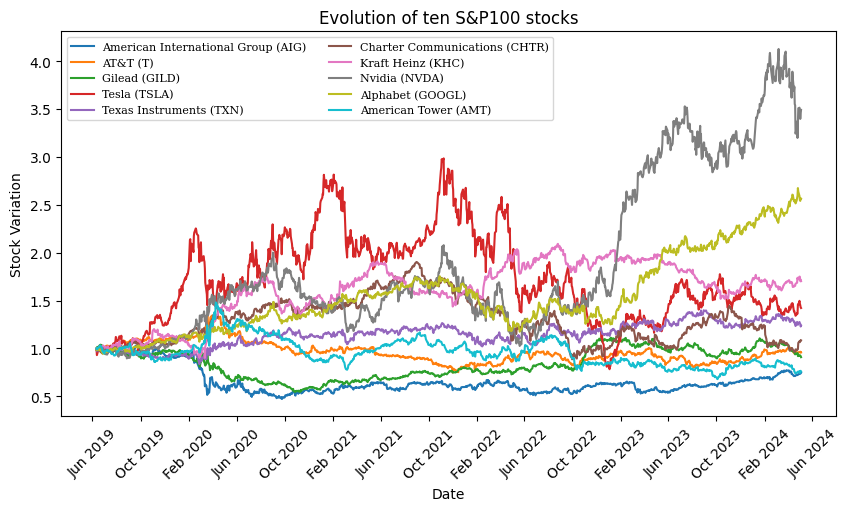

In [27]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumprod(1 + values.loc[stock]["Variation"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Variation')
plt.legend(ncol=2, loc="upper left", prop={'size': 8, 'family': 'serif'})
plt.show()

In [28]:
values.to_csv("../data/SP100/raw/values.csv")